### Recommendation System (Collaborative Filtering Based Recommender Systems using Low Rank Matrix Factorization)

In this notebook we are going to learn how to create a recommendation system that will be able to predict the rating of a movie given the `userId` and the `movieId`, so basically we are going to create a model using tensorflow and keras that will be able to predict the vote that the user will give to a certain movie.


### Imports 

Let's import all the packages that we are going to use throughout this notebook.



In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pylab import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
import tensorflow as tf
import random

from IPython.display import SVG               
import numpy as np  
import os                   


In [2]:
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

### Dataset

The dataset that we will be using is coming from [kaggle](https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset) And we will load it from my google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next we are going to define the base path to our files.

In [4]:
base_path = '/content/drive/My Drive/REC SYS/MOVIE_LENS-100K'
assert os.path.exists(base_path), f'the file path {base_path} does not exists.'

So in this folder we have 2 files the `movies.csv` and the `ratings.csv` let's have a look at them.

In [6]:
rating_df = pd.read_csv(os.path.join(base_path, 'ratings.csv'))
movies_df = pd.read_csv(os.path.join(base_path, 'movies.csv'))

In [8]:
rating_df.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
movies_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We aregoing to use the `rating_df` so we will make a copy of it and start working with it, we will be intrested in predicting the rating the user will give to a certain movie.

In [10]:
df = rating_df.copy()

Let's check the userIds that we have in our dataframe

In [11]:
df.userId.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Note that in total we have 671 unique users whose userid range from `1->671`. Next let's have a look on the unique movies that we have.

In [12]:
df.movieId.unique()

array([  31, 1029, 1061, ...,  129, 4736, 6425])

In [13]:
len(df.movieId.unique())

9066

We have `9, 066` unique movies that the user is rating. Next let's check for now values in our dataframe.

In [14]:
df.userId.isnull().sum()

0

In [15]:
df.rating.isnull().sum()

0

In [16]:
df.movieId.isnull().sum()

0

Let's check the minimum and maximum rating that we have in this dataset.

In [17]:
df.rating.min()

0.5

In [18]:
df.rating.max()

5.0

### Encoding the columns
Note that the users that we have in this dataframe have voted for at least `20` movies. 

In [19]:
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [22]:
df.userId.value_counts(ascending=True)

0        20
497      20
447      20
444      20
443      20
       ... 
72     1610
14     1700
623    1735
563    1868
546    2391
Name: userId, Length: 671, dtype: int64

### Creating the Utility Matrix

In [23]:
index=list(df['userId'].unique())
columns=list(df['movieId'].unique())
index=sorted(index)
columns=sorted(columns)
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId')

1. This is the utility matrix; for each of the `671` users arranged rowwise; each column shows the rating of the movie given by a particular user.

2. Note that majority of the matrix is filled with `'Nan'` which shows that majority of the movies are unrated by many users.

3. For each movie-user pair if the entry is NOT `'Nan'` the vaue indicates the rating given by user to that corressponding movie.

4. For now we will fill the `'Nan'` value with value `'0'`. But note that this just is just indicative, a `0` implies `NO RATING` and doesn't mean that user has rated 0 to that movie. It doesn't at all represent any rating.



In [24]:
util_df

movieId,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
util_df.fillna(0)

movieId,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's create a training and validation sets from our dataframe.

In [26]:
users = df.userId.unique()
movies = df.movieId.unique()
userid2idx = {j:i for i, j in enumerate(users)}
movieid2idx = {j:i for i, j in enumerate(movies)}

In [27]:
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(80054, 4) (19950, 4)


### Matrix Factorization

1. Now we move on to the main of the notebook that is `Matrix Factorization`. In matrix facorization, we basically break a matrix into usually `2` smaller matrices each with smaller dimensions. these matrices are oftem called `'Embeddings'`. We can have variants of Matrix Factorizartion:
* `Low Rank MF` 
* `Non-Negaive MF` (NMF)
* and so on..

2. Here we are going to use `'Low Rank Matrix Factorization'`. We have created embeddings for both user as well as the item; movie in our case. The number of dimensions or the so called `'Latent Factors'` in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering.


Next let's create embeddings and create a model from them.

In [35]:
n_movies = len(movies)
n_users = len(users)
n_latent_factors=64 

In [47]:
user_input = keras.layers.Input(shape=(1,),name='user_input',dtype='int64')
user_embedding = keras.layers.Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec = keras.layers.Flatten(name='flatten_users')(user_embedding)


movie_input = keras.layers.Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding = keras.layers.Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='flatten_movies')(movie_embedding)

sim = keras.layers.Dot(axes=1, name='simalarity_dot-product')([user_vec,movie_vec])
model = keras.models.Model([user_input, movie_input], sim, name="model-x")
model.summary()

(None, 64) (None, 64)
Model: "model-x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        42944       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 64)        580224      ['movie_input[0][0]']            
                                                                      

1. First we need to create embeddings for both the `user` as well as the item or `movie`. For this I have used the `Embedding` layer from keras.

2. Specify the input expected to be embedded (Both in user and item embedding). The use a `Embedding` layer which expects the no of latent factors in the resulting embedding and also the no of users or items.

3. Then we take the `'Dot-Product'` of both the embeddings using the `'merge' ` layer. Note that `'dot-product'` is just a measure of simalrity and we can use any other mode like `'mulitply'` or `'cosine simalarity'` or `'concatenate' ` etc youc can find merging layers here -> https://keras.io/api/layers/merging_layers/

4. Lastly we make a Keras model from the specified details.

In [51]:
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),loss='mse')

Note that the metrics used is `'Mean squared Error'`. Our aim is to minimize the `mse` on the training set ie over the values which the user has rated (100004 ratings).

In [52]:
rating_df.shape

(100004, 4)

In [53]:
batch_size=128
epochs=50

In [54]:
history = model.fit([train.userId, train.movieId], 
                    train.rating, batch_size=batch_size,
                    epochs =epochs, 
                    validation_data = ([valid.userId, valid.movieId], valid.rating),
                    verbose=1
)

Epoch 1/50
626/626 [==============================] - 6s 4ms/step - loss: 13.6651 - val_loss: 13.7231
Epoch 2/50
626/626 [==============================] - 2s 3ms/step - loss: 13.6540 - val_loss: 13.7193
Epoch 3/50
626/626 [==============================] - 3s 5ms/step - loss: 13.6328 - val_loss: 13.6989
Epoch 4/50
626/626 [==============================] - 2s 3ms/step - loss: 13.5743 - val_loss: 13.6176
Epoch 5/50
626/626 [==============================] - 2s 3ms/step - loss: 13.4053 - val_loss: 13.3735
Epoch 6/50
626/626 [==============================] - 2s 3ms/step - loss: 13.0057 - val_loss: 12.8459
Epoch 7/50
626/626 [==============================] - 2s 3ms/step - loss: 12.2842 - val_loss: 11.9882
Epoch 8/50
626/626 [==============================] - 2s 4ms/step - loss: 11.2471 - val_loss: 10.8536
Epoch 9/50
626/626 [==============================] - 3s 5ms/step - loss: 9.9841 - val_loss: 9.5540
Epoch 10/50
626/626 [==============================] - 2s 3ms/step - loss: 8.6195 - 

Evaluating the Model Performance

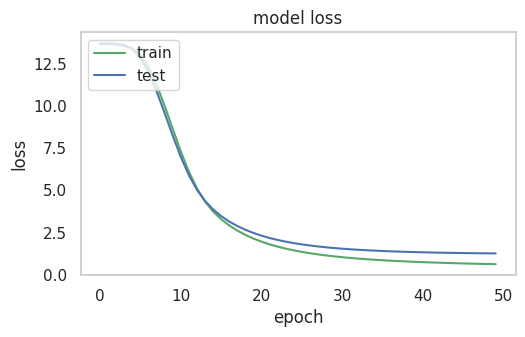

In [58]:
rcParams['figure.figsize'] = 5, 3
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(False)
plt.show()

### Using a Neural Network
Now let us focus on using a `NN` to matrix factorization, this way is not much different from the previous approach.The main difference is that we will use `Fully Connected` layers as well as the `Dropout` layers and the `BatchNormalization` layers.

The number of units and the number of layers etc.. are the hyperparametrs here as in a traditional neural network.


### Creating the Embeddings
Note that I we aregoing to use `50` latent factors as that seems to give reasonable performance. Further tuning and careful optimization can give even better results.

In [59]:
n_latent_factors=50

In [60]:
user_input = keras.layers.Input(shape=(1,),name='user_input',dtype='int64')
user_embedding = keras.layers.Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec = keras.layers.Flatten(name='flatten_users')(user_embedding)
user_vec = keras.layers.Dropout(0.5)(user_vec)


movie_input = keras.layers.Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding = keras.layers.Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='flatten_movies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.5)(movie_vec)

sim = keras.layers.Dot(axes=1, name='simalarity_dot-product')([user_vec,movie_vec])


nn_inp = keras.layers.Dense(96,activation='relu')(sim)
nn_inp = keras.layers.Dropout(0.4)(nn_inp)
nn_inp = keras.layers.Dense(1,activation='relu')(nn_inp)
nn_model = keras.models.Model([user_input, movie_input],nn_inp, name="model-y")
nn_model.summary()

Model: "model-y"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        33550       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        453300      ['movie_input[0][0]']            
                                                                                            

In [62]:
nn_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),loss='mse')

In [63]:
batch_size=128
epochs=20

In [64]:
history = nn_model.fit([train.userId, train.movieId], 
                    train.rating, batch_size=batch_size,
                    epochs =epochs, 
                    validation_data = ([valid.userId, valid.movieId], valid.rating),
                    verbose=1
)

Epoch 1/20
626/626 [==============================] - 3s 4ms/step - loss: 2.8769 - val_loss: 1.1123
Epoch 2/20
626/626 [==============================] - 2s 4ms/step - loss: 1.2625 - val_loss: 1.1105
Epoch 3/20
626/626 [==============================] - 3s 4ms/step - loss: 1.1963 - val_loss: 1.0440
Epoch 4/20
626/626 [==============================] - 3s 5ms/step - loss: 1.0503 - val_loss: 0.9655
Epoch 5/20
626/626 [==============================] - 4s 6ms/step - loss: 0.9431 - val_loss: 0.9186
Epoch 6/20
626/626 [==============================] - 3s 5ms/step - loss: 0.8673 - val_loss: 0.8924
Epoch 7/20
626/626 [==============================] - 2s 4ms/step - loss: 0.8160 - val_loss: 0.8747
Epoch 8/20
626/626 [==============================] - 2s 4ms/step - loss: 0.7794 - val_loss: 0.8616
Epoch 9/20
626/626 [==============================] - 4s 6ms/step - loss: 0.7388 - val_loss: 0.8535
Epoch 10/20
626/626 [==============================] - 3s 4ms/step - loss: 0.7133 - val_loss: 0.8482

Ploting the model train history

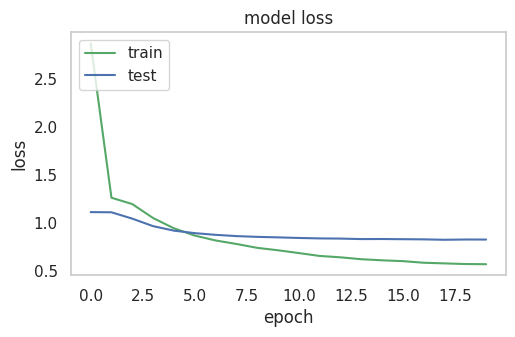

In [65]:
rcParams['figure.figsize'] = 5, 3
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(False)
plt.show()

Our model is performing well, let's try to make some predictions using this model. We want to predict how the user will rate a particular movie.

1. `userId = 0`	
2. `movieId = 0`
3. `actual ratting = 2.5`

In [93]:
df.tail(20)

,userId,movieId,rating,timestamp
99984,670,1225,2.0,1066793004
99985,670,1240,2.0,1065111990
99986,670,361,3.0,1065112004
99987,670,126,4.0,1065111863
99988,670,1260,4.0,1064245557
99989,670,483,4.5,1064891627
99990,670,362,3.0,1064891549
99991,670,127,4.0,1063502711
99992,670,364,4.0,1065111963
99993,670,1299,3.5,1064245507


In [89]:
train.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205
5,0,5,2.0,1260759151


In [91]:
pred = model.predict([np.array([0]), np.array([0])], verbose=0)
print(np.squeeze(pred))

2.3263617


In [87]:
pred = model.predict([np.array([0]), np.array([1])], verbose=0)
print(np.squeeze(pred))

2.5219212


In [94]:
pred = model.predict([np.array([670]), np.array([1308])], verbose=0)
print(np.squeeze(pred))

3.8761387
